## One Cross-Validation Function to Rule Them All 

To install:
<pre>
pip install rdkit useful_rdkit_utils lightgbm catboost scikit-learn pingouin scipy matplotlib numpy 
</pre>

In [2]:
import pandas as pd
import useful_rdkit_utils as uru
from rdkit.Chem import rdFingerprintGenerator
from sklearn.metrics import r2_score, mean_absolute_error
from lgbm_wrapper import LGBMMorganCountWrapper
from catboost_wrapper import CatBoostWrapper
from rdkit import Chem
from sort_and_slice_ecfp_featuriser import create_sort_and_slice_ecfp_featuriser
import pingouin as pg
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import warnings
from collections import defaultdict

The **cross_validate** function provides a flexible means of running nested cross-validation experiments. It's easy to compare descriptors, machine learning models or combinations of the two.  The function allows facile incorporation of different splitting strategies.  Random, scaffold, and cluster splits are supported out of the box. Other strategies can be trivially incorporated. 

The function accepts a few arguments.  
- **df** - A Pandas dataframe, the dataframe must have a SMILES column 
- **model_list** - a list of tuples where the first element is a string indicating the model name, and the second element is a function that returns a scikit-learn compatible model 
- **y_col** - the column in **df** with the y value for the model 
- **group_list** - a list of tuples where the first element contains the group name and the second argment is a function to calculate the groups.  This argument can be used to split according to groups (e.g. scaffold or cluster splitting).  To perform a random split, set each row in df to a unique value. 
- **n_outer** - the number of rounds of cross validation
- **n_inner** - the number of folds to perform at each round 

The return value is a list of dictionaries that can be easily transformed into a Pandas dataframe.  More on this below. 

Here's the docstring. 

In [3]:
help(uru.cross_validate)

Help on function cross_validate in module useful_rdkit_utils.split_utils:

cross_validate(df: pandas.core.frame.DataFrame, model_list: List[Tuple[str, Callable[[str], object]]], y_col: str, group_list: List[Tuple[str, Callable[[pandas.core.series.Series], pandas.core.series.Series]]], n_outer: int = 5, n_inner: int = 5) -> List[dict]
    Perform cross-validation on a dataset using multiple models and grouping strategies.
    
    :param df: The input dataframe containing the data.
    :param model_list: A list of tuples where each tuple contains a model name and a callable that returns a model instance.
    :param y_col: The name of the target column.
    :param group_list: A list of tuples where each tuple contains a group name and a callable that assigns groups based on the SMILES column.
    :param n_outer: The number of outer folds for cross-validation. Default is 5.
    :param n_inner: The number of inner folds for cross-validation. Default is 5.
    :return: A dataframe containin

The best way to explain **cross_validate** is with an example.  Let's compare the Morgan counts fingerprint from the RDKit with the recently published [Sort and Slice fingerprint](https://arxiv.org/abs/2403.17954).  We'll examine the input argments one at a time. 

### df - The input pandas DataFrame
The input dataframe must have two components. 
- A SMILES column titled **SMILES**
- A column with a y-value, this can have any name 

First we'll read in some data.  We'll use the solubility set from the [Biogen ADME datasets](https://github.com/molecularinformatics/Computational-ADME). 

In [4]:
df = pd.read_csv("data/biogen_logS.csv")
df.head()

,Internal ID,Vendor ID,SMILES,CollectionName,logS
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,-5.548020
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,-5.071409
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,-3.925969
3,Mol6,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,emolecules,-4.535280
4,Mol9,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,enamineBB_pmc,-4.709963


### model_list - A list of tuples where each tuple contains a model name and a function to create the model.

ML models are defined with a simple function that returns a scikit-learn compatible model.  The model must support the **fit** and **predict** methods. Calling the functions this way enables arguments to be passed to the model. 

In [5]:
# define functions 
def gen_LGBMRegressor():
    return LGBMRegressor()

def gen_CatBoostRegressor():
    return CatBoostRegressor(verbose=False)

# create a list of names and functions
model_list = [["LGBM",gen_LGBMRegressor],["CatBoost",gen_CatBoostRegressor]]

### y_col - The name of the target column in the DataFrame
The **y_col** argument specifies the **y** variable.  In this case, it's **logS**. 

In [6]:
df.head()

,Internal ID,Vendor ID,SMILES,CollectionName,logS
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,-5.548020
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,-5.071409
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,-3.925969
3,Mol6,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,emolecules,-4.535280
4,Mol9,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,enamineBB_pmc,-4.709963


### group_list - A list of tuples where each tuple contains a group name and a function to calculate the group

Splitting functions take a SMILES list as input and return a list of integers corresponding to groups.  Here are a couple of examples.  The first takes a list of SMILES and returns a unique index for each.  This just produces a random split.   The second takes the same input and returns a list of cluster ids.  The *cross_validation* function will not put molecules from the same cluster into both training and test sets. 

The **useful_rdkit_utils** library has four splitting functions.  
- get_random_split
- get_bemis_murcko_clusters
- get_butina_clusters 
- get_kmeans clusters - I'm still figuring out the best way to use this one

The code below shows how two of these functions are implemented. 

In [7]:
# define functions
def get_random_split(smiles_list):
    return list(range(0, len(smiles_list)))

def get_butina_clusters(smiles_list):
    fp_list = [uru.smi2morgan_fp(x) for x in smiles_list]
    return uru.taylor_butina_clustering(fp_list)

# create a list of names and functions 
group_list = [["butina",uru.get_butina_clusters],["random",get_random_split]]

Now let's apply **cross_validate**.  We will define 

Two models
- [LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)
- [CatBoostRegressor](https://catboost.ai/docs/en/concepts/python-quickstart)

Two grouping methods
- random (random_split)
- butina (split based on Butina clustering) 

### Run cross_validate

In [8]:
y = "logS"
model_list = [("lgbm_morgan", LGBMMorganCountWrapper),("catboost",CatBoostWrapper)]
group_list = [("random", uru.get_random_clusters),("butina", uru.get_butina_clusters)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result_df = uru.cross_validate(df,model_list,y,group_list)
print("Cross-validation complete")

  0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation complete


### Calculate Statitics
Now we'll calculate stats, let's get the test set rows from result_df. 

In [9]:
test_df = result_df.query("dset=='test'")
test_df

,Internal ID,Vendor ID,SMILES,CollectionName,logS,dset,group,fold,lgbm_morgan,catboost
3,Mol6,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,emolecules,-4.535280,test,random,0,-3.843501,-4.150159
4,Mol9,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,enamineBB_pmc,-4.709963,test,random,0,-4.436934,-4.555533
8,Mol18,44507857,CCCc1cc(N2CCc3c(nc(C4CC4)n3C)C2)n2ncnc2n1,emolecules,-3.801702,test,random,0,-3.680288,-3.863477
12,Mol25,53744933,Nc1n[nH]cc1-c1cc(Cl)ccc1Oc1cc(F)c(S(=O)(=O)Nc2...,emolecules,-4.224051,test,random,0,-5.291320,-5.266075
15,Mol28,322748925,O=C(Nc1cccnc1)c1ccnc(NC(=O)C2CC2)c1,emolecules,-3.840588,test,random,0,-3.950254,-3.906528
...,...,...,...,...,...,...,...,...,...,...
2129,Mol3454,4025818,Cn1c(NC(=O)c2ccn(COc3ccccc3)n2)nc2ccccc21,emolecules,-4.777374,test,butina,24,-4.364794,-4.350956
2135,Mol3460,11979193,COc1ccccc1-c1nc(-c2ccc(NC(C)=O)cc2)c(C)s1,emolecules,-5.666149,test,butina,24,-4.976673,-4.809409
2141,Mol3466,11477117,CC(C)NS(=O)(=O)c1ccc2c(c1)oc(=O)c1cc(S(=O)(=O)...,emolecules,-5.969898,test,butina,24,-4.291572,-4.369439
2170,Mol3495,37024444,CC(C)(C)Cc1nnc(-c2cnc3onc(C4CCCC4)c3c2)o1,emolecules,-4.912777,test,butina,24,-4.188045,-4.390208


Calculate $R^2$ and MAE 

In [10]:
model_names = [x[0] for x in model_list]
stats_list = [("R2",r2_score),("MAE",mean_absolute_error)]
stat_names = [x[0] for x in stats_list]
res_list = []
for [fold, group],v in test_df.groupby(["fold","group"]):
    for m in model_names:
        stats_vals = []
        for stat_name, stat_func in stats_list:
            stats_vals.append(stat_func(v[y],v[m]))
        res_list.append([fold,m,group]+stats_vals)

In [11]:
stat_df = pd.DataFrame(res_list,columns=["Fold","Model","Split"]+[x[0] for x in stats_list])
stat_df

,Fold,Model,Split,R2,MAE
0,0,lgbm_morgan,butina,0.278359,0.450731
1,0,catboost,butina,0.295009,0.447434
2,0,lgbm_morgan,random,0.397114,0.385194
3,0,catboost,random,0.396433,0.383519
4,1,lgbm_morgan,butina,0.225363,0.401199
...,...,...,...,...,...
95,23,catboost,random,0.408200,0.395645
96,24,lgbm_morgan,butina,0.335613,0.408987
97,24,catboost,butina,0.342362,0.401791
98,24,lgbm_morgan,random,0.302876,0.394666


### Analysis
**This section is designed to show you how to work with the output from cross_validate.  It is not necessarily intended to demonstrate best practices for model comparsion** For more information on statistical best practices, please see the [Polaris notebooks](https://github.com/polaris-hub/polaris-method-comparison/blob/main/ADME_example/ML_Regression_Comparison.ipynb). 

Plot the $R^2$ and MAE distributions to see if they're roughly normal. 

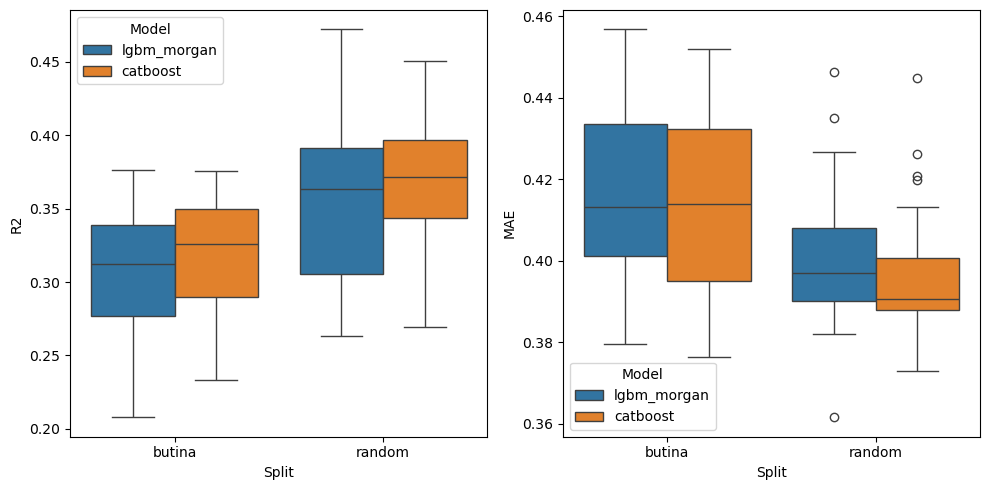

In [12]:
figure, axes = plt.subplots(1,2,figsize=(10,5))
ax0 = sns.boxplot(y="R2",x="Split",hue="Model",data=stat_df,ax=axes[0])
ax1 = sns.boxplot(y="MAE",x="Split",hue="Model",data=stat_df,ax=axes[1])
plt.tight_layout()

Calculate p-values and Cohen's d

In [13]:
def cohen_d(s1,s2):
    return np.abs(np.mean(s1-s2)/np.std(s1-s2))

In [14]:
for split in stat_df.Split.unique():
    split_df = stat_df.query("Split == @split")
    for model in stat_df.Model.unique():
        stat_comp_list = []
        for stat in stat_names:
            stat_comp_list.append(stat_df.query("Model == @model")[stat].values)
        p_value = ttest_ind(stat_comp_list[0], stat_comp_list[1]).pvalue
        d = cohen_d(stat_comp_list[0], stat_comp_list[1])
        print(split,model,p_value,f"{d:0.2f}")

butina lgbm_morgan 3.373575376270397e-15 1.12
butina catboost 3.41174456392251e-12 0.93
random lgbm_morgan 3.373575376270397e-15 1.12
random catboost 3.41174456392251e-12 0.93


In [15]:
butina_df = stat_df.query("Split == 'butina'").copy()

Transform the dataframe for plots

In [16]:
butina_df["idx"] = range(0,len(butina_df))
id_vars = ["idx","Split","Fold","Model"]
melt_df = butina_df.drop("MAE",axis=1).melt(id_vars=id_vars)
melt_df.head()

,idx,Split,Fold,Model,variable,value
0,0,butina,0,lgbm_morgan,R2,0.278359
1,1,butina,0,catboost,R2,0.295009
2,2,butina,1,lgbm_morgan,R2,0.225363
3,3,butina,1,catboost,R2,0.271504
4,4,butina,2,lgbm_morgan,R2,0.312075


### Plot Paired Plots for $R^2$ and MAE
I find the [paired plot](https://pingouin-stats.org/build/html/generated/pingouin.plot_paired.html) from pingouin to be a useful visual for comparing models.  The plot shows boxplots of the metrics from two variants.  In this case, we're comparing two fingerprint types.  We have lines connecting individual cross-validation folds, with an increase between methods in green and a decrease in red.  Each line represents one cross-validation fold. Ideally, we'd like to see the same color for all the lines.  If we see some red lines and some green lines this indicates less of a difference between methods. Here's the paired plot for $R^2$

Text(0.5, 1.0, '$R^2$')

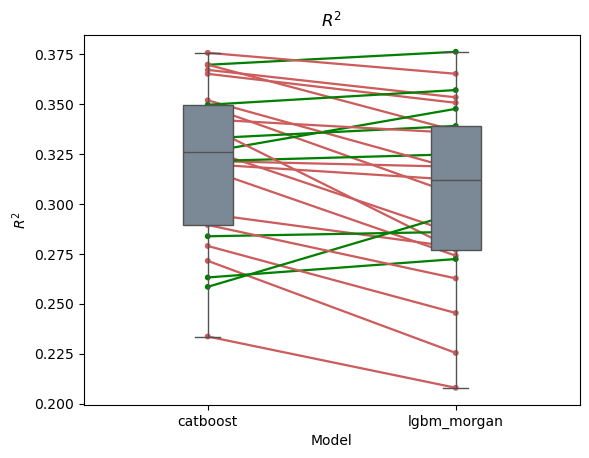

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax = pg.plot_paired(melt_df, dv="value",subject="Fold",within="Model")
ax.set_xlabel("Model")
ax.set_ylabel("$R^2$");
ax.set_title("$R^2$")

Make a paired plot for MAE

Text(0.5, 1.0, 'MAE')

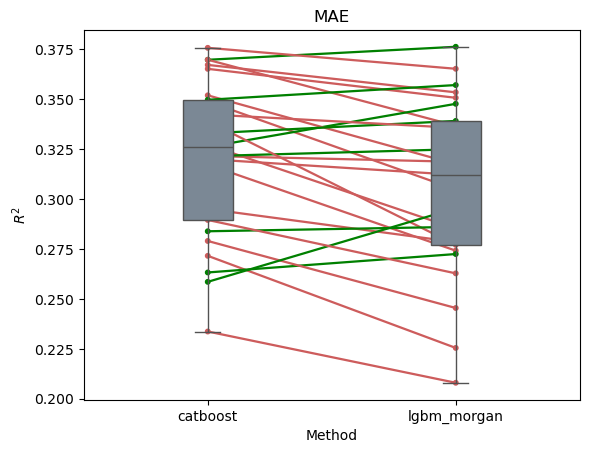

In [18]:
melt_df = butina_df.drop("MAE",axis=1).melt(id_vars=id_vars)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax = pg.plot_paired(melt_df, dv="value",subject="Fold",within="Model")
ax.set_xlabel("Method")
ax.set_ylabel("$R^2$");
ax.set_title("MAE")